In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import SeparableConv2D
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import concurrent.futures

In [2]:
# Configuration
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 50

In [3]:
def load_image_pair(blur_path, sharp_path):
    blur_img = load_img(blur_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    sharp_img = load_img(sharp_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    blur_arr = img_to_array(blur_img) / 255.0
    sharp_arr = img_to_array(sharp_img) / 255.0
    return blur_arr, sharp_arr

In [4]:
def process_image_pair(args):
    blur_img_path, sharp_img_path = args
    if os.path.exists(sharp_img_path):
        return load_image_pair(blur_img_path, sharp_img_path)
    return None

def load_dataset(blurred_root='blurred', sharp_root='leftImg8bit/train'):
    X, Y = [], []
    image_pairs = []

    for blur_type_intensity in os.listdir(blurred_root):
        blur_train_path = os.path.join(blurred_root, blur_type_intensity, 'train')
        for city in os.listdir(blur_train_path):
            blur_city_path = os.path.join(blur_train_path, city)
            sharp_city_path = os.path.join(sharp_root, city)

            for blur_filename in os.listdir(blur_city_path):
                blur_img_path = os.path.join(blur_city_path, blur_filename)
                sharp_img_path = os.path.join(sharp_city_path, blur_filename)
                image_pairs.append((blur_img_path, sharp_img_path))

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_image_pair, image_pairs))

    for result in results:
        if result:
            X.append(result[0])
            Y.append(result[1])

    return np.array(X), np.array(Y)


    return np.array(X), np.array(Y)
X_train, Y_train = load_dataset()

In [5]:
# U-Net definition
BASE_FILTERS = 32
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(inputs)
    c1 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(p1)
    c2 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 =SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(p2)
    c3 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(p3)
    c4 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(p4)
    c5 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(u6)
    c6 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(u7)
    c7 =SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c7)

    u8 = layers.UpSampling2D()(c7)
    u8 = layers.concatenate([u8, c2])
    c8 =SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(u8)
    c8 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c8)

    u9 = layers.UpSampling2D()(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(u9)
    c9 = SeparableConv2D(BASE_FILTERS, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [45]:
model = unet_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=200, validation_split=0.1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_18           │ (None, 256, 256, 32)      │             155 │ input_layer_1[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_19           │ (None, 256, 256, 32)      │           1,344 │ separable_conv2d_18[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 128, 128, 32)      │               0 │ separable_conv2d_19[0][0]  │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_20           │ (None, 128, 128, 32)      │           1,344 │ max_pooling2d_4[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_21           │ (None, 128, 128, 32)      │           1,344 │ separable_conv2d_20[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 64, 64, 32)        │               0 │ separable_conv2d_21[0][0]  │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_22           │ (None, 64, 64, 32)        │           1,344 │ max_pooling2d_5[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_23           │ (None, 64, 64, 32)        │           1,344 │ separable_conv2d_22[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 32, 32, 32)        │               0 │ separable_conv2d_23[0][0]  │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_24           │ (None, 32, 32, 32)        │           1,344 │ max_pooling2d_6[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_25           │ (None, 32, 32, 32)        │           1,344 │ separable_conv2d_24[0][0]  │
│ (SeparableConv2D)             │                           │               

 Total params: 28,350 (110.74 KB)

 Trainable params: 28,350 (110.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 254s 665ms/step - loss: 0.0333 - mae: 0.1298 - val_loss: 0.0030 - val_mae: 0.0332
Epoch 2/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 247s 687ms/step - loss: 0.0025 - mae: 0.0302 - val_loss: 0.0018 - val_mae: 0.0250
Epoch 3/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 245s 683ms/step - loss: 0.0014 - mae: 0.0226 - val_loss: 0.0016 - val_mae: 0.0233
Epoch 4/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 242s 674ms/step - loss: 0.0011 - mae: 0.0200 - val_loss: 0.0015 - val_mae: 0.0219
Epoch 5/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 233s 650ms/step - loss: 9.1100e-04 - mae: 0.0173 - val_loss: 0.0014 - val_mae: 0.0212
Epoch 6/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 247s 689ms/step - loss: 8.2228e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0200
Epoch 7/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 235s 656ms/step - loss: 8.0370e-04 - mae: 0.0156 - val_loss: 0.0014 - val_mae: 0.0200
Epoch 8/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 228s 637ms/step - loss: 7.7151e-04 - mae: 0.0150 - val_loss: 0.0014 - val_mae: 0.0196


In [21]:
model = tf.keras.models.load_model("unet_denoising_model_200.keras")


C:\Users\HARSH SAXENA\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 58 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
def load_blurred_image(img_path):
    img = load_img(img_path, target_size=(256, 256))
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

img_path = "blurred/gaussian_medium/test/berlin/berlin_000026_000019_leftImg8bit.png"
input_img = load_blurred_image(img_path)

In [25]:
predicted = model.predict(input_img)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


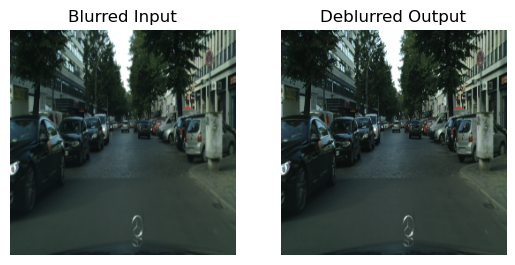

In [27]:
original_img = np.squeeze(input_img, axis=0)
plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


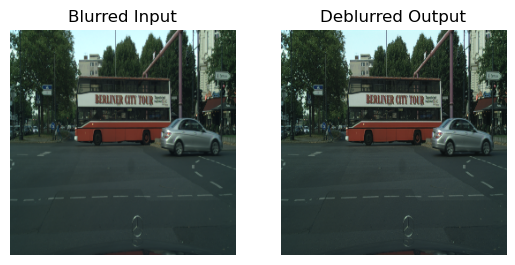

In [29]:
img_path = "blurred/gaussian_mild/test/berlin/berlin_000011_000019_leftImg8bit.png"
input_img = load_blurred_image(img_path)
predicted = model.predict(input_img)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)
original_img = np.squeeze(input_img, axis=0)
plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


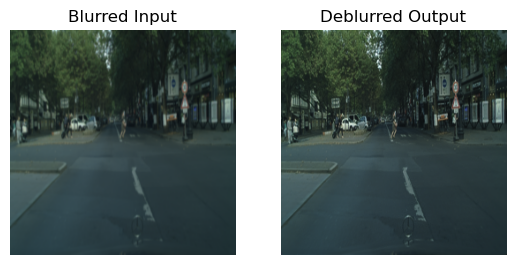

In [31]:
img_path = "blurred/gaussian_strong/test/berlin/berlin_000020_000019_leftImg8bit.png"
input_img = load_blurred_image(img_path)
predicted = model.predict(input_img)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)
original_img = np.squeeze(input_img, axis=0)
plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


(-0.5, 255.5, 255.5, -0.5)

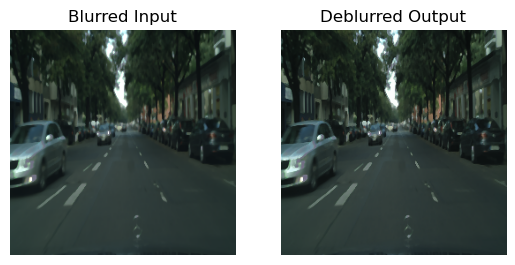

In [33]:
img_path = "blurred/median_strong/test/berlin/berlin_000007_000019_leftImg8bit.png"
input_img = load_blurred_image(img_path)
predicted = model.predict(input_img)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)
original_img = np.squeeze(input_img, axis=0)
plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


(-0.5, 255.5, 255.5, -0.5)

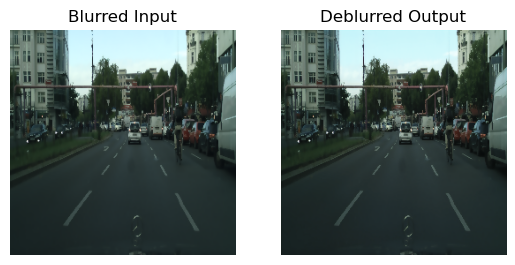

In [35]:
img_path = "blurred/bilateral_strong/test/berlin/berlin_000010_000019_leftImg8bit.png"
input_img = load_blurred_image(img_path)
predicted = model.predict(input_img)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)
original_img = np.squeeze(input_img, axis=0)
plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


(-0.5, 255.5, 255.5, -0.5)

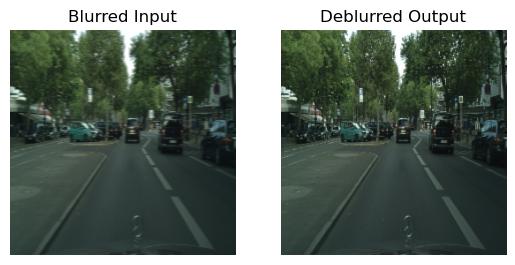

In [37]:
img_path = "blurred/motion_strong/test/berlin/berlin_000001_000019_leftImg8bit.png"
input_img = load_blurred_image(img_path)
predicted = model.predict(input_img)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)
original_img = np.squeeze(input_img, axis=0)

plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


(-0.5, 255.5, 255.5, -0.5)

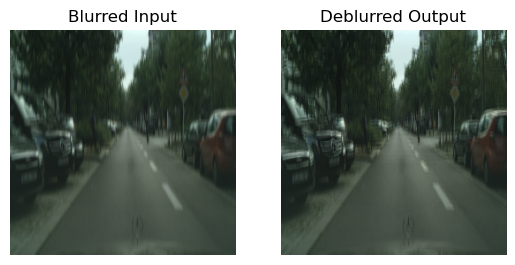

In [39]:
img_path = "blurred/motion_vertical_strong/test/berlin/berlin_000004_000019_leftImg8bit.png"
input_img = load_blurred_image(img_path)
predicted = model.predict(input_img)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)
original_img = np.squeeze(input_img, axis=0)
plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


(-0.5, 255.5, 255.5, -0.5)

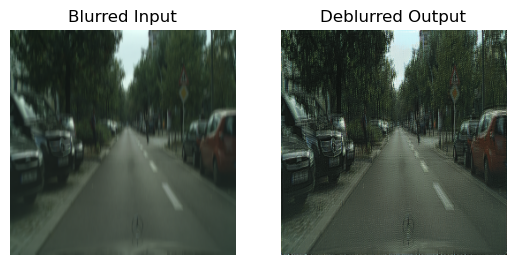

In [47]:
#running the model multiple times
predicted = model.predict(predicted)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)
original_img = np.squeeze(input_img, axis=0)
plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


(-0.5, 255.5, 255.5, -0.5)

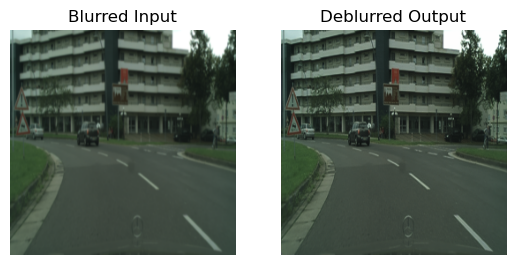

In [49]:
img_path = "aachen_000000_000019_blurred.png"
input_img = load_blurred_image(img_path)
predicted = model.predict(input_img)
img = np.squeeze(predicted, axis=0) 
predicted_img = (img * 255.0).astype(np.uint8)
original_img = np.squeeze(input_img, axis=0)
plt.subplot(1, 2, 1)
plt.title("Blurred Input")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Deblurred Output")
plt.imshow(predicted_img) 
plt.axis('off')
#predicted_img = cv2.resize(predicted_img, (2048, 1024))
#predicted_img = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2RGB)
#cv2.imwrite('aachen_output.png', predicted_img)

In [ ]:
#model.save("unet_denoising_model_200.h5")
#model.save("unet_denoising_model_200.keras")